<a href="https://colab.research.google.com/github/moimigueldev/tensorflow-ztm/blob/main/tensorflow/06_transfer_learning_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow part3: Scaling Up -> Food Vision Mini

We've seen the power of transfer leraning feature extractions, fine tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of 
food)

Our goal is to beat the original Food101 paper with 10% of the training data (levaraging the power of deep learning)

[Original Food 101 Paper (PDF)](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)

Our baseline to beat is 50.76% accuracy across 101 classes.



In [ ]:
# Check to see. if we're using a GPU
!nvidia-smi

Sat Jun 11 21:54:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks we've created a series of helper functions to do different task. 
Lets download them

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-11 21:54:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-11 21:54:01 (61.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food 101 paper with 10% of the trainig data, so let's download it

The data we're downloading comes from the origina Food101 dataset but has been preprocessed using the image_data_modification notebook 

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

--2022-06-11 21:54:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.148.128, 209.85.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   193MB/s    in 8.5s    

2022-06-11 21:54:16 (183 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# walk_through_dir('101_food_classes_10_percent')

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE=(224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  label_mode='categorical',
  image_size=IMG_SIZE,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  label_mode='categorical',
  image_size=IMG_SIZE,
  shuffle=False # don't shuffle test data for prediction analysis
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the big seps we're going to take:

* Create a ModelCheckpoint callback
* Create a daga augmentation layer to build data augmentation into the model
* Build a headless (no top layers) Functional EfficientNetB0 backbone model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and we'll validate on only 15% of test data, to save epoch time)

In [ ]:
# Create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path ,
    save_weights_only=True ,
    save_best_only=True,
    monitor='val_accuracy',
)

In [ ]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.),
], name='data_augmentation')

In [ ]:
# Setup the base model and freeze its layers (this will extract features)
input_shape=IMG_SIZE + (3,)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name='input_layer')

x = data_augmentation(inputs) # This only happens during training face

x = base_model(x, training=False) # Put the base_model in infrence mode so weights which need to tay frozen, stay frozen

x = layers.GlobalAveragePooling2D(name='average_pool_layer')(x)

outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)



16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 average_pool_layer (GlobalA  (None, 1280)             0         
 veragePooling2D)                                                
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Compile & Fit
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

history_all_classes_10_percent = model.fit(
  train_data_all_10_percent,
  epochs=5,
  steps_per_epoch=len(train_data_all_10_percent),
  validation_data =test_data,
  validation_steps=int(0.15 * len(test_data)),
  callbacks=[checkpoint_callback]
)


Epoch 1/5
237/237 [==============================] - 54s 161ms/step - loss: 3.4760 - accuracy: 0.2444 - val_loss: 2.7010 - val_accuracy: 0.3980
Epoch 2/5
237/237 [==============================] - 32s 134ms/step - loss: 2.3475 - accuracy: 0.4593 - val_loss: 2.2725 - val_accuracy: 0.4539
Epoch 3/5
237/237 [==============================] - 31s 127ms/step - loss: 1.9752 - accuracy: 0.5317 - val_loss: 2.1029 - val_accuracy: 0.4807
Epoch 4/5
237/237 [==============================] - 30s 123ms/step - loss: 1.7615 - accuracy: 0.5741 - val_loss: 2.0372 - val_accuracy: 0.4857
Epoch 5/5
237/237 [==============================] - 28s 118ms/step - loss: 1.6070 - accuracy: 0.6079 - val_loss: 2.0001 - val_accuracy: 0.4876


In [ ]:
# Evaluate the model 
feature_extraction_results = model.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 1.7024 - accuracy: 0.5580


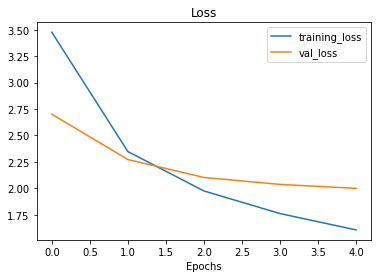

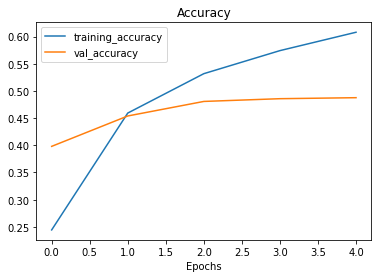

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

**Question:** What do these curves suggest? Hint: Ideally curves should be pretty close to each other, if not then that means the model is overfitted to the traiing data

## Fine Tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze
for layer in base_model.layers[:-5]:
  layer.trainable = False


In [ ]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])

In [ ]:
# What layers in the model is trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
average_pool_layer True
dense True


In [ ]:
# Check wich layers are trainalbe in our base_model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Fine tune for 5 more epocs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), This is the total number of epochs were' after 

# Fine tune our model
history_all_classes_10_percent_fine_tune = model.fit(
    train_data_all_10_percent,
    epochs=fine_tune_epochs,
    validation_data= test_data,
    validation_steps=int(0.15 * len(test_data)),
    initial_epoch=history_all_classes_10_percent.epoch[-1]
)

Epoch 5/10
237/237 [==============================] - 36s 123ms/step - loss: 1.3483 - accuracy: 0.6556 - val_loss: 1.9193 - val_accuracy: 0.5040
Epoch 6/10
237/237 [==============================] - 27s 114ms/step - loss: 1.2433 - accuracy: 0.6679 - val_loss: 1.9281 - val_accuracy: 0.5019
Epoch 7/10
237/237 [==============================] - 27s 114ms/step - loss: 1.1395 - accuracy: 0.7005 - val_loss: 1.8942 - val_accuracy: 0.5119
Epoch 8/10
237/237 [==============================] - 28s 118ms/step - loss: 1.0860 - accuracy: 0.7104 - val_loss: 1.8909 - val_accuracy: 0.5151
Epoch 9/10
237/237 [==============================] - 26s 110ms/step - loss: 1.0325 - accuracy: 0.7251 - val_loss: 1.9331 - val_accuracy: 0.5037
Epoch 10/10
237/237 [==============================] - 26s 110ms/step - loss: 0.9536 - accuracy: 0.7501 - val_loss: 1.9321 - val_accuracy: 0.5058


In [ ]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)

790/790 [==============================] - 54s 68ms/step - loss: 1.6068 - accuracy: 0.5778


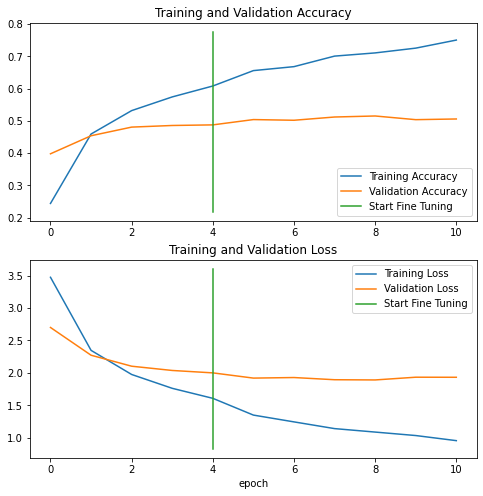

In [ ]:
# Compare the histories of feature extraction model with fine tuning model
compare_historys(history_all_classes_10_percent, history_all_classes_10_percent_fine_tune, 5)

# Saving and loading our model

To use our model in external model in an external application, we'll need to save it and export it somewhere

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save('/content/drive/MyDrive/deep-learning/saved_models/tensorflow/101_food_classes_10_percent')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/deep-learning/saved_models/tensorflow/101_food_classes_10_percent/assets


In [ ]:
# Load and evaluate saved model

loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/deep-learning/saved_models/tensorflow/101_food_classes_10_percent')

In [ ]:
# Evaluate loaded model and comeare performace to presaved model
loaded_models_results = loaded_model.evaluate(test_data)
loaded_models_results



790/790 [==============================] - 56s 69ms/step - loss: 1.6068 - accuracy: 0.5778


[1.606755256652832, 0.577782154083252]

In [ ]:
# The results from the model above should be similar
all_classes_10_percent_fine_tune_results

[1.606755256652832, 0.577782154083252]

## Evaluating the performance of the big dog model across all different classes

Let's make some predictiosn, visualize them and then later find out which peredictions were the most wrong

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-06-11 22:05:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.183.128, 173.194.194.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.183.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   120MB/s    in 0.4s    

2022-06-11 22:05:40 (120 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data('06_101_food_class_10_percent_saved_big_dog_model.zip')

In [ ]:
# Download pretrained model
model = tf.keras.models.load_model('06_101_food_class_10_percent_saved_big_dog_model')

In [ ]:
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 56s 70ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

# Making predictions with our trained model

In [ ]:
# Make predictions with our model
preds_probs = model.predict(test_data, verbose=1) # Verbose to hee how long is left

790/790 [==============================] - 56s 69ms/step


In [ ]:
790 * 32, len(test_data)

(25280, 790)

In [ ]:
# How many predictions are there?
len(preds_probs)

25250

In [ ]:
# What's the shape of our predicitions
preds_probs.shape

(25250, 101)

In [ ]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9542134e-02, 3.5742110e-06, 4.1376989e-02, ..., 1.4138677e-09,
        8.3530736e-05, 3.0897488e-03],
       [9.6401680e-01, 1.3753246e-09, 8.4780541e-04, ..., 5.4286997e-05,
        7.8362507e-12, 9.8466213e-10],
       [9.5925868e-01, 3.2533582e-05, 1.4866934e-03, ..., 7.1891060e-07,
        5.4397316e-07, 4.0275772e-05],
       ...,
       [4.7313222e-01, 1.2931199e-07, 1.4805659e-03, ..., 5.9749966e-04,
        6.6969100e-05, 2.3469256e-05],
       [4.4571884e-02, 4.7265442e-07, 1.2258486e-01, ..., 6.3498392e-06,
        7.5318376e-06, 3.6778590e-03],
       [7.2438973e-01, 1.9249813e-09, 5.2311054e-05, ..., 1.2291399e-03,
        1.5792777e-09, 9.6395757e-05]], dtype=float32)

In [ ]:
# What does the first predictions probability array look like?
preds_probs[0]

array([5.9542134e-02, 3.5742110e-06, 4.1376989e-02, 1.0660594e-09,
       8.1614573e-09, 8.6639469e-09, 8.0927026e-07, 8.5652727e-07,
       1.9859068e-05, 8.0977821e-07, 3.1727796e-09, 9.8673718e-07,
       2.8532225e-04, 7.8048884e-10, 7.4230251e-04, 3.8916369e-05,
       6.4740229e-06, 2.4977251e-06, 3.7891088e-05, 2.0678401e-07,
       1.5538462e-05, 8.1507005e-07, 2.6230512e-06, 2.0010719e-07,
       8.3827507e-07, 5.4215920e-06, 3.7391094e-06, 1.3150555e-08,
       2.7761490e-03, 2.8051913e-05, 6.8562661e-10, 2.5574802e-05,
       1.6688893e-04, 7.6406981e-10, 4.0452849e-04, 1.3150681e-08,
       1.7957424e-06, 1.4448199e-06, 2.3062952e-02, 8.2466835e-07,
       8.5365667e-07, 1.7138624e-06, 7.0525148e-06, 1.8402163e-08,
       2.8553370e-07, 7.9483289e-06, 2.0681648e-06, 1.8525219e-07,
       3.3619635e-08, 3.1522560e-04, 1.0410960e-05, 8.5448096e-07,
       8.4741843e-01, 1.0555463e-05, 4.4094864e-07, 3.7404097e-05,
       3.5306119e-05, 3.2489061e-05, 6.7314468e-05, 1.2852564e

In [ ]:
len(preds_probs[0]), sum(preds_probs[0])

(101, 1.0000000775306805)

Our model outputs a prediction probability array (with N number of varialbes where N is the number of classes for each sample passes to the predict method)

In [ ]:
# We got one prediction probability per class, in our case, there is 101 prediction probabilities
print(f'Number of prediction probabilities for sample 0: {len(preds_probs[0])}')
print(f'What prediction probability sample 0 looks like:\n{ preds_probs[0]}')
print(f'The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}')

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
[5.9542134e-02 3.5742110e-06 4.1376989e-02 1.0660594e-09 8.1614573e-09
 8.6639469e-09 8.0927026e-07 8.5652727e-07 1.9859068e-05 8.0977821e-07
 3.1727796e-09 9.8673718e-07 2.8532225e-04 7.8048884e-10 7.4230251e-04
 3.8916369e-05 6.4740229e-06 2.4977251e-06 3.7891088e-05 2.0678401e-07
 1.5538462e-05 8.1507005e-07 2.6230512e-06 2.0010719e-07 8.3827507e-07
 5.4215920e-06 3.7391094e-06 1.3150555e-08 2.7761490e-03 2.8051913e-05
 6.8562661e-10 2.5574802e-05 1.6688893e-04 7.6406981e-10 4.0452849e-04
 1.3150681e-08 1.7957424e-06 1.4448199e-06 2.3062952e-02 8.2466835e-07
 8.5365667e-07 1.7138624e-06 7.0525148e-06 1.8402163e-08 2.8553370e-07
 7.9483289e-06 2.0681648e-06 1.8525219e-07 3.3619635e-08 3.1522560e-04
 1.0410960e-05 8.5448096e-07 8.4741843e-01 1.0555463e-05 4.4094864e-07
 3.7404097e-05 3.5306119e-05 3.2489061e-05 6.7314468e-05 1.2852564e-08
 2.6219754e-10 1.0318126e-05 8.5744177e-05 1.0

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

#How do they look?
pred_classes



array([ 52,   0,   0, ..., 100,  94, 100])

In [ ]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all of ourmode's predicions, to evaluate them, we need to compare them the original test dataset labels

In [ ]:
# To get our test labels we need to unravel our test data batch dataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())


y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our models predictions

One way to check that our models's predictiosn array is in the same order as our test labels array is to find the accuracy score


In [ ]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [ ]:
# Let's try scikitlearn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
# Does this metric come close to our models evaluate results
import numpy as np
np.isclose(sklearn_accuracy, results_downloaded_model[1])

True

## Let's get visual: Making our confusion matrix

In [ ]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to confusion_matrix function
def make_confusion_matrixs(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  

  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Changed (plot x-labels vertically)
  plt.xticks(rotation=70, fontsize=20)
  plt.yticks(fontsize=20)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

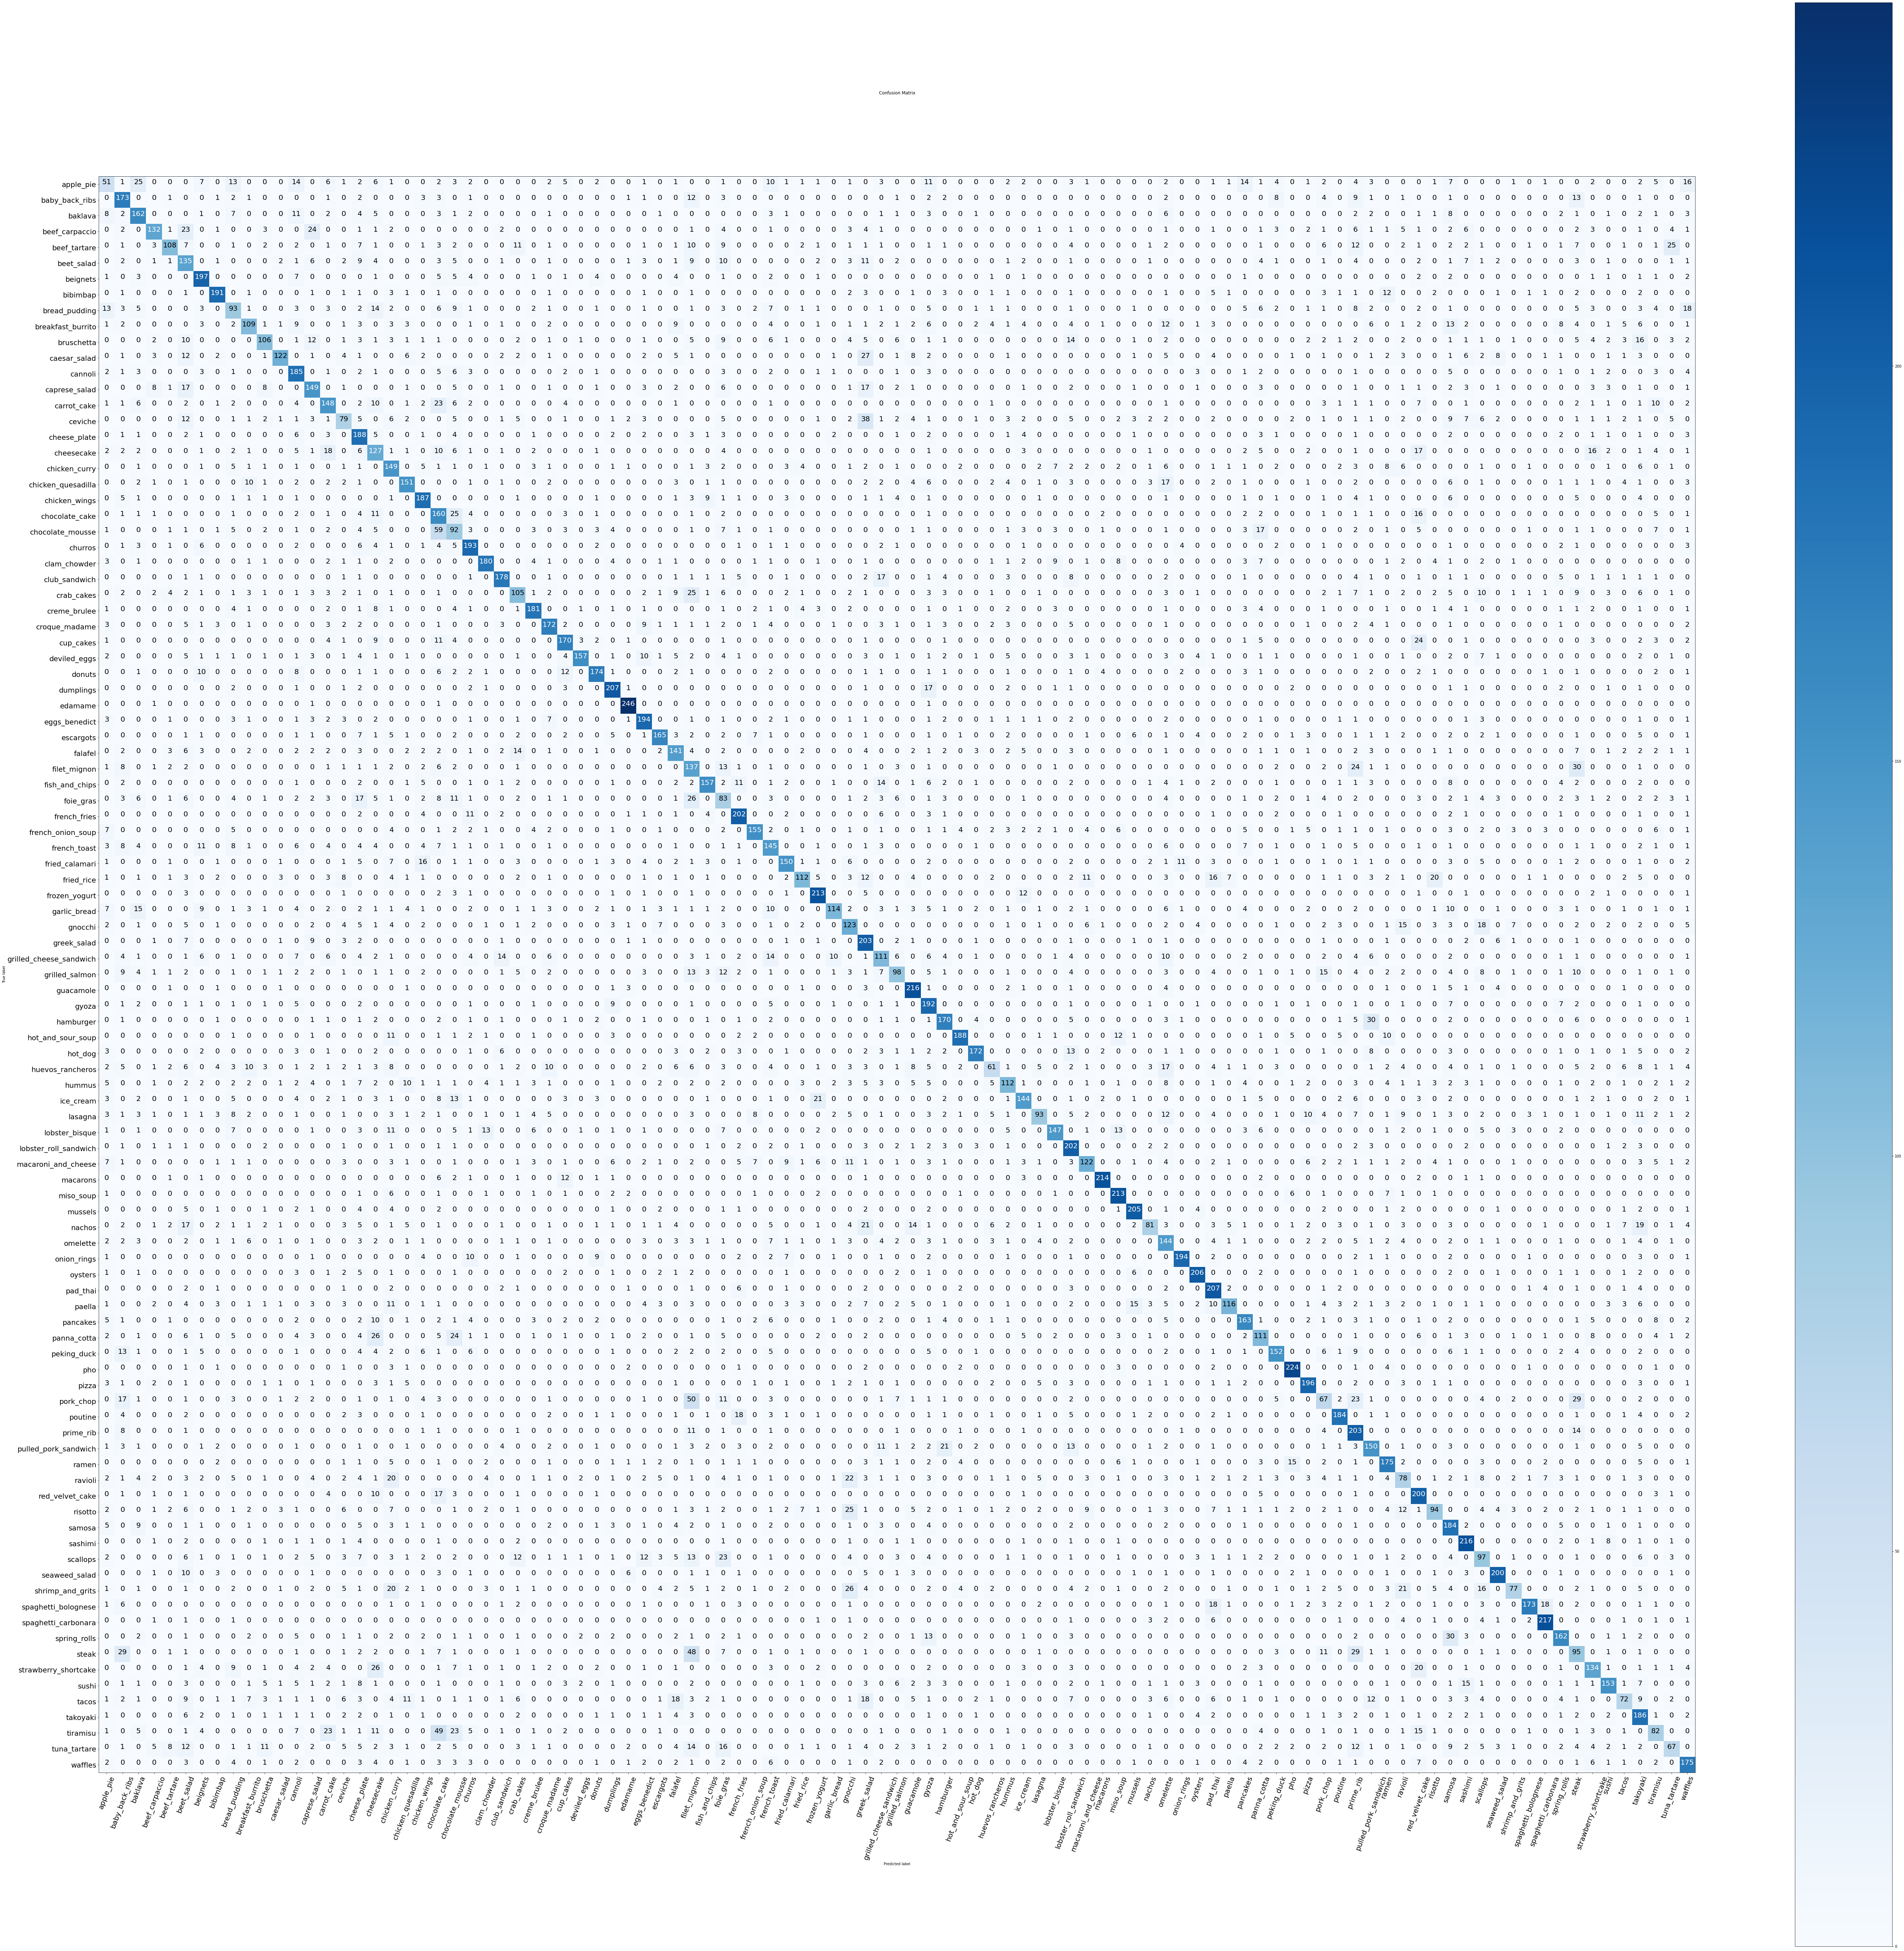

In [ ]:
from helper_functions import make_confusion_matrix
make_confusion_matrixs(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True
                      )

## Let's keep the evaluation train going, time for a classification report

sklearn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall , and f1) called classifcation report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our models predictions, but with so many classes, they're quite hard to understand, how about we create a visualization to create a better understanding

In [ ]:
# Get a dictionary of the classification repoort
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

Let's plot all of our classes f1 scores

In [ ]:
classification_report_dict['99']['f1-score']

0.35356200527704484

In [ ]:
# Create empty dictionary 
class_f1_scores = {}

# Loop through classifcatioon_report_dict items
for k, v in classification_report_dict.items():
  if k == 'accuracy': # Stop once we get to accuracy key
    break
  else:
    # Add class names and f1 scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v['f1-score']
# class_f1_scores

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({'class_names':list(class_f1_scores.keys()), 
                          'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

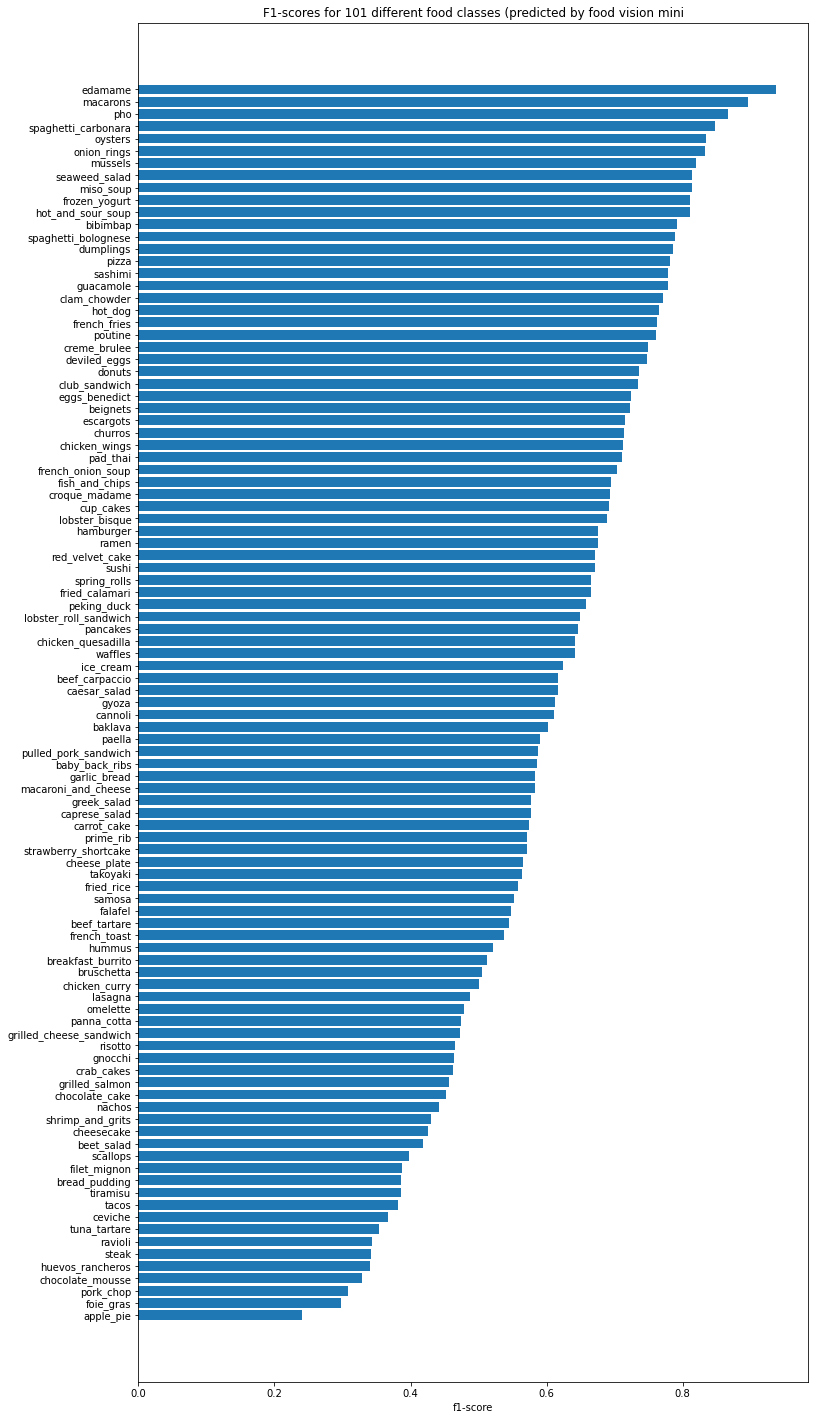

In [ ]:
import matplotlib.pyplot as plt

fig, ax  = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores.class_names)
ax.set_xlabel('f1-score')
ax.set_title('F1-scores for 101 different food classes (predicted by food vision mini')
ax.invert_yaxis()



## Visualizing predictions on custom images

Now this is the real test on food images not even in our test dataset (our own image)

To visualize our mode's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:

* Read in a target image filepath using tf.io.read_file()
* Turn the images into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the iamges our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [61]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into specificed shape (img_shape, img_shape, 3)

  Args:
  filename (str): path to target image
  image_shape (int): height/width dimensions of target image size
  scale (bool): scale pixel values from 0-255 to 0-1 or not
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Read in the image
  img = tf.io.decode_image(img, channels=3) # Works for PNGs

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/no
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientgNet models in TensorFlow
    

Now we've got a function to load and prepare target images, let's now write some code to visualize image, their target laberl and tour model's prediction.

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loades images
3. Plot the original images along with the model's predictions, prediction probability and truth label


101_food_classes_10_percent/test/oysters/2696591.jpg
(224, 224, 3)
101_food_classes_10_percent/test/french_toast/2872314.jpg
(224, 224, 3)
101_food_classes_10_percent/test/baby_back_ribs/2079924.jpg
(224, 224, 3)


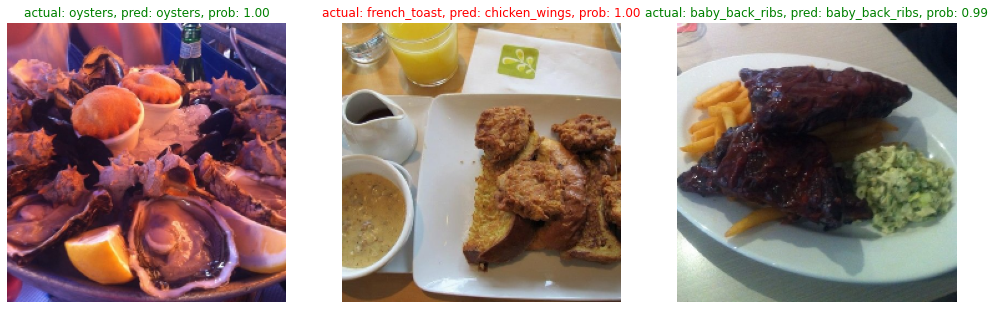

In [90]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))

for i in range(3):
  class_name = random.choice(class_names)
  filename=random.choice(os.listdir(test_dir + '/' + class_name))
  filepath = test_dir + class_name + '/'  + filename
  print(filepath)
  
  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  print(img.shape)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = model.predict(img_expanded) # Get prediction prob array
  pred_class = class_names[pred_prob.argmax()] # Get hightest pred prob index
  # print(pred_prob, pred_class)

  # Plot the images
  plt.subplot(1, 3, i +1)

  plt.imshow(img/255.)
  if class_name == pred_class: # If predicted class matches truth class make text green
    title_color = 'g'
  else:
    title_color = 'r'
  
  plt.title(f'actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}', c=title_color)
  plt.axis(False)


## Finding the most wrong predictions

To find out where our model is most wrong, lets' write some code to find out the following:
1. Get all of the image filepaths in the test dataset (listfiles() method)
2. Create a pandas DataFrame of the image filepats, ground truth labels, predictied classes (from our model), max prediction probabilities, prediction class names, ground truth class names.
3. We can use our dataframe to find all the wrong prediction (Where the ground truth label doesn't match the prediction)
4. Sort the DataFrame based on wrong predictions. (Have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction


In [93]:
# Get all of image filepaths in the test dataset
filepaths = []

for filepath in test_data.list_files('/content/101_food_classes_10_percent/test/*/*.jpg', shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [94]:
# Create a dataframe of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({'img_path': filepaths,
                        'y_true': y_labels,
                        'y_pred': pred_classes,
                        'pred_cof': preds_probs.max(axis=1), # Get the maximum prediction probability value
                        'y_true_classname': [class_names[i] for i in y_labels],
                        'y_pred_classname': [class_names[i] for i in pred_classes],
                        })

pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_cof y_true_classname      y_pred_classname  
0      0.847418        apple_pie                 gyoza  
1      0.964017        apple_pie             apple_pie  
2      0.959259        apple_pie             apple_pie  
3      0.658607        apple_pie  pulled_pork_sandwich  
4      0.367900        apple_pie             prime_rib  
...         ...              ...                   ...  
25245  0.972823          waffles               waffles  
25246  0.878027          waffles          cheese_plate  
25247  0.537899          waffles               waffles  
25248  0.501951          waffles  strawberry_shortcake  
25249  0.690628          waffles               waffles  

[25250 rows x 6 columns]

In [95]:
# Find out in our dataframe which predictions are wrong

pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_cof y_true_classname      y_pred_classname  pred_correct  
0      0.847418        apple_pie                 gyoza         False  
1      0.964017        apple_pie             apple_pie          True  
2      0.959259        apple_pie             apple_pie          True  
3      0.658607        apple_pie  pulled_pork_sandwich         False  
4      0.367900        apple_pie             prime_rib         False  
...         ...              ...                   ...           ...  
25245  0.972823          waffles               waffles          True  
25246  0.878027          waffles          cheese_plate         False  
25247  0.537899          waffles               waffles          True  
25248  0.501951          waffles  strawberry_shortcake         False  
25249  0.690628          waffles               waffles          True  

[25250 rows x 7 columns]

In [98]:
# Sort our dataframe to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df['pred_correct'] == False].sort_values('pred_cof', ascending=False)[:100]
top_100_wrong

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
...                                                  ...     ...     ...   
8763   b'/content/101_food_classes_10_percent/test/es...      35      41   
2663   b'/content/101_food_classes_10_percent/test/br...      10      61   
7924   b'/content/101_food_classes_10_percent/test/do...      31      29   
18586  b'/content/101_food_classes_10_percent/test/pe...      74      39   
3519   b'/content/101_food_classes_10_percent/test/ca...      14      21   

       pred_cof       y_true_classname       y_pred_classname  pred_correct  
21810  0.999997               scallops              cup_cakes         False  
231    0.999995              apple_pie                waffles         False  
15359  0.999988  lobster_roll_sandwich              hamburger         False  
23539  0.999987   strawberry_shortcake        red_velvet_cake         False  
21400  0.999981                 samosa           spring_rolls         False  
...         ...                    ...                    ...           ...  
8763   0.997169              escargots      french_onion_soup         False  
2663   0.997055             bruschetta  lobster_roll_sandwich         False  
7924   0.997020                 donuts              cup_cakes         False  
18586  0.996885            peking_duck              foie_gras         False  
3519   0.996842            carrot_cake         chocolate_cake         False  

[100 rows x 7 columns]

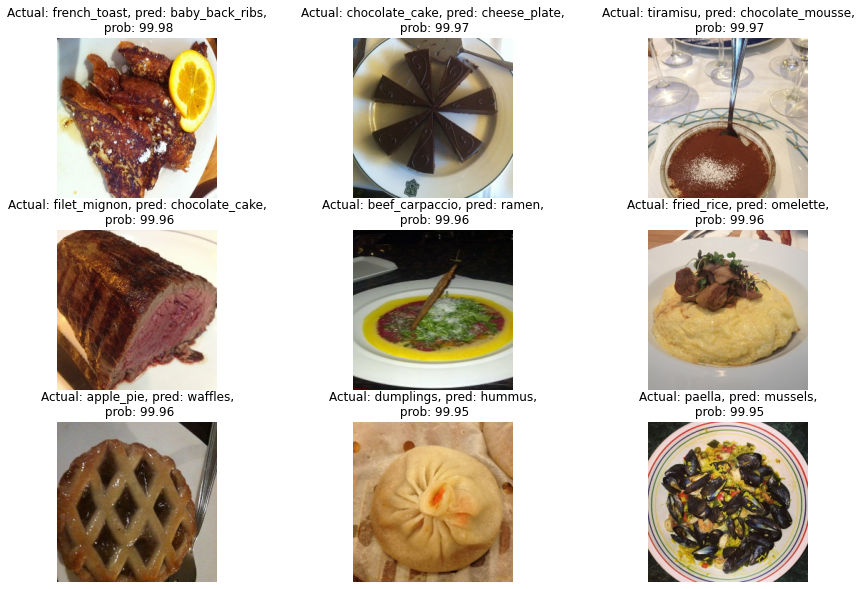

In [110]:
# Visualzie data samples which have the wrong prediction but highest pred probality

images_to_view = 9
start_index = 20
plt.figure(figsize=(15, 10))

for i, row in enumerate(top_100_wrong[start_index: start_index + images_to_view].itertuples()):
  plt.subplot(3, 3, i + 1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _ , pred_prob, y_true_classname, y_pred_classname, _ = row # Only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f'Actual: {y_true_classname}, pred: {y_pred_classname},\n prob: {(pred_prob * 100):.2f}')
  plt.axis(False)


# Test out the big dog model on our own custom images


In [112]:
# Get custom images 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data('custom_food_images.zip')

--2022-06-11 23:36:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.161.128, 142.250.152.128, 74.125.70.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.161.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2022-06-11 23:36:01 (110 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [116]:
# Get the custom food images filepaths 
custom_food_images = ['custom_food_images/' + img_path for img_path in os.listdir('custom_food_images')]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg']

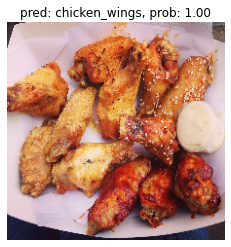

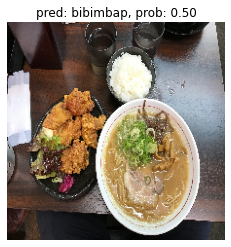

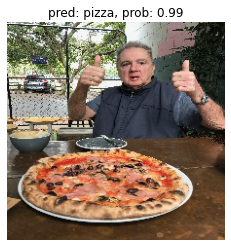

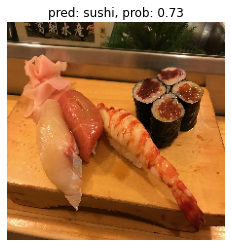

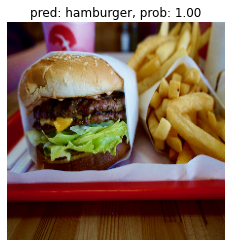

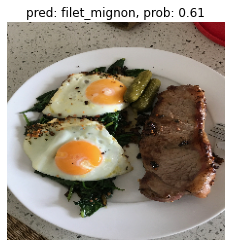

In [120]:
# Make predictions on  and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # Don't need to scale for efficientNEt
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()] # Get the index with the highest pred prob
  # Plot the appropricate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f'pred: {pred_class}, prob: {pred_prob.max():.2f}')
  plt.axis(False)